In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display, Markdown, Latex
import scipy
import matplotlib.transforms as mtrans
import string

In [2]:
def meta_analysis(effects, se, method="random", weights=None):
    # From Omer Weissbrod
    assert method in ["fixed", "random"]
    d = effects
    variances = se ** 2

    # compute random-effects variance tau2
    vwts = 1.0 / variances
    fixedsumm = vwts.dot(d) / vwts.sum()
    Q = np.sum(((d - fixedsumm) ** 2) / variances)
    df = len(d) - 1
    tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))

    # defing weights
    if weights is None:
        if method == "fixed":
            wt = 1.0 / variances
        else:
            wt = 1.0 / (variances + tau2)
    else:
        wt = weights

    # compute summtest
    summ = wt.dot(d) / wt.sum()
    if method == "fixed":
        varsum = np.sum(wt * wt * variances) / (np.sum(wt) ** 2)
    else:
        varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
    ###summtest = summ / np.sqrt(varsum)

    summary = summ
    se_summary = np.sqrt(varsum)

    return summary, se_summary

In [3]:
gwas_gene_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fdr1-{n}" for n in [2000]]
    + [f"fwer5-{n}" for n in [2000]]
)

gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_gene_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

# Numerical table for the results

In [4]:
df_plot = pd.read_csv("power-analysis.csv")

# normalize by the average statistics (across method) for each trait, rep_i
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].mean()
    df_plot_normalized.append(df_group)
df_plot = pd.concat(df_plot_normalized)

SUBSAMPLING_SCALE = np.sqrt(10000 / 110824)

# Estimate Oracle performance

In [5]:
# oracle fixing weight options
df_tmp = df_plot[df_plot.method.str.endswith("-zscore.vs")]
# get of maximum across configurations
df_oracle = df_tmp.groupby(["trait", "rep_i"]).apply(lambda x: x["tstats"].max())
df_oracle_mean = df_oracle.groupby("trait").mean()
df_oracle_se = df_oracle.groupby("trait").std() * SUBSAMPLING_SCALE
print(
    "Oracle with optimal n. genes, fixing weightings as -zscore.vs",
    meta_analysis(df_oracle_mean, df_oracle_se),
)

# oracle fixing gene seletion method
df_tmp = df_plot[df_plot.method.str.startswith("top-1000")]
df_oracle = df_tmp.groupby(["trait", "rep_i"]).apply(lambda x: x["tstats"].max())
df_oracle_mean = df_oracle.groupby("trait").mean()
df_oracle_se = df_oracle.groupby("trait").std() * SUBSAMPLING_SCALE
print(
    "Oracle with optimal weightings, fixing n. genes as top-1000",
    meta_analysis(df_oracle_mean, df_oracle_se),
)

# oracle for all methods
df_tmp = df_plot
df_oracle = df_tmp.groupby(["trait", "rep_i"]).apply(lambda x: x["tstats"].max())
df_oracle_mean = df_oracle.groupby("trait").mean()
df_oracle_se = df_oracle.groupby("trait").std() * SUBSAMPLING_SCALE
print("Oracle across all methods", meta_analysis(df_oracle_mean, df_oracle_se))

Oracle with optimal n. genes, fixing weightings as -zscore.vs (1.407524793041335, 0.03273808744181459)
Oracle with optimal weightings, fixing n. genes as top-1000 (1.2537502345649747, 0.026762281220057083)
Oracle across all methods (1.430920577969929, 0.03072427462732523)


# meta-analyze across traits for each method

In [6]:
# Calculate the mean and SE for each trait and method across 20 replicates
df_mean = df_plot.groupby(["trait", "method"]).mean().reset_index()
df_se = df_plot.groupby(["trait", "method"]).std().reset_index()

# correct for sub-sampling
metric_list = ["n_discovery", "tstats", "meanshift"]
for metric in metric_list:
    df_se[metric] *= SUBSAMPLING_SCALE

dict_df_res = dict()
for metric in metric_list:
    df_res = []
    # for each method, calculate the mean and se across 20 traits
    for method in df_plot.method.unique():
        method_mean, method_se = meta_analysis(
            df_mean[df_mean.method == method][metric],
            df_se[df_se.method == method][metric],
        )
        df_res.append([method, method_mean, method_se])
    df_res = pd.DataFrame(df_res, columns=["method", "mean", "se"])

    # format results
    #     df_res["gene_selection"] = df_res["method"].apply(
    #         lambda x: x.split(".")[0].rsplit("-", 1)[0]
    #     )
    #     df_res["gwas_weight"] = df_res["method"].apply(
    #         lambda x: x.split(".")[0].rsplit("-", 1)[1]
    #     )
    #     df_res["sc_weight"] = df_res["method"].apply(lambda x: x.split(".")[1])
    #     df_res["mean+se"] = (
    #         df_res["mean"].round(3).astype(str)
    #         + "("
    #         + df_res["se"].round(3).astype(str)
    #         + ")"
    #     )
    #     df_res = (
    #         df_res[["gene_selection", "gwas_weight", "sc_weight", "mean+se"]]
    #         .set_index(["gene_selection", "gwas_weight", "sc_weight"])
    #         .unstack(level=0)
    #         .reset_index()
    #     )
    #     df_res = df_res.set_index(["gwas_weight", "sc_weight"])["mean+se"][gwas_gene_list]
    dict_df_res[metric] = df_res

<ipython-input-2-a0893a5a92a4>:12: RuntimeWarning: invalid value encountered in double_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
<ipython-input-2-a0893a5a92a4>:28: RuntimeWarning: invalid value encountered in double_scalars
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)


In [7]:
display(dict_df_res["tstats"])
dict_df_res["tstats"].reset_index().to_excel("tstats.xlsx", index=False)

# df_tmp = dict_df_res["tstats"].reset_index()
# df_tmp.columns.name = None
# df_tmp.reset_index(drop=True).rename(
#     columns={
#         "gwas_weight": "GWAS",
#         "sc_weight": "single-cell",
#         "top-100": "Top 100",
#         "top-500": "Top 500",
#         "top-1000": "Top 1,000",
#         "top-2000": "Top 2,000",
#         "fdr1-2000": "FDR < 1%",
#         "fwer5-2000": "FWER < 5%",
#     }
# ).replace({"vs": "VS", "zscore": "Z"})

,method,mean,se
0,top-100-zscore.uniform,0.721892,0.064343
1,top-100-zscore.vs,0.798281,0.063376
2,top-100-uniform.uniform,0.711983,0.061527
3,top-100-uniform.vs,0.787581,0.062737
4,top-500-zscore.uniform,0.928701,0.033636
5,top-500-zscore.vs,1.090812,0.048217
6,top-500-uniform.uniform,0.910227,0.036332
7,top-500-uniform.vs,1.060475,0.052745
8,top-1000-zscore.uniform,1.037667,0.021952
9,top-1000-zscore.vs,1.231668,0.027768


# pairwise comparison with the default settings

In [8]:
# df for the default method (top-1000-zscore.vs)
df_method_default = df_plot[df_plot.method == "top-1000-zscore.vs"].reset_index()

df_pairwise_res = []
for method in df_plot.method.unique():
    # for each other method
    df_method = df_plot[df_plot.method == method].reset_index()
    assert np.all(df_method_default.trait == df_method.trait)
    assert np.all(df_method_default.rep_i == df_method.rep_i)

    # compare the difference with the default method to this method
    # for each trait, calculate the mean and SE over 20 data sets
    df_diff = (
        pd.DataFrame(
            {
                "trait": df_method_default.trait,
                "rep_i": df_method_default.rep_i,
                "tstats_diff": df_method_default.tstats - df_method.tstats,
            }
        )
        .groupby("trait")
        .agg({"tstats_diff": ["mean", "std"]})
    )["tstats_diff"]
    df_diff["std"] *= SUBSAMPLING_SCALE
    # filter trait with zero sem
    df_diff = df_diff[df_diff["std"] > 0]
    # meta-analyze across 20 traits
    mean, se = meta_analysis(df_diff["mean"], df_diff["std"])

    df_pairwise_res.append([method, mean, se])

df_pairwise_res = pd.DataFrame(
    df_pairwise_res, columns=["method", "mean", "se"]
).set_index("method")

# calculate one-sided p-value based on z-score
df_pairwise_res["pval"] = scipy.stats.norm.sf(
    df_pairwise_res["mean"] / df_pairwise_res["se"]
)

<ipython-input-2-a0893a5a92a4>:9: RuntimeWarning: invalid value encountered in double_scalars
  fixedsumm = vwts.dot(d) / vwts.sum()
<ipython-input-2-a0893a5a92a4>:12: RuntimeWarning: invalid value encountered in double_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
<ipython-input-2-a0893a5a92a4>:24: RuntimeWarning: invalid value encountered in double_scalars
  summ = wt.dot(d) / wt.sum()
<ipython-input-2-a0893a5a92a4>:28: RuntimeWarning: invalid value encountered in double_scalars
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)


In [10]:
from matplotlib.patches import Patch

Default method:
                          mean        se
method                                  
top-100-zscore.vs     0.798281  0.063376
top-500-zscore.vs     1.090812  0.048217
top-1000-zscore.vs    1.231668  0.027768
top-2000-zscore.vs    1.242396  0.032754
fdr1-2000-zscore.vs   1.113315  0.031031
fwer5-2000-zscore.vs  1.102960  0.039894


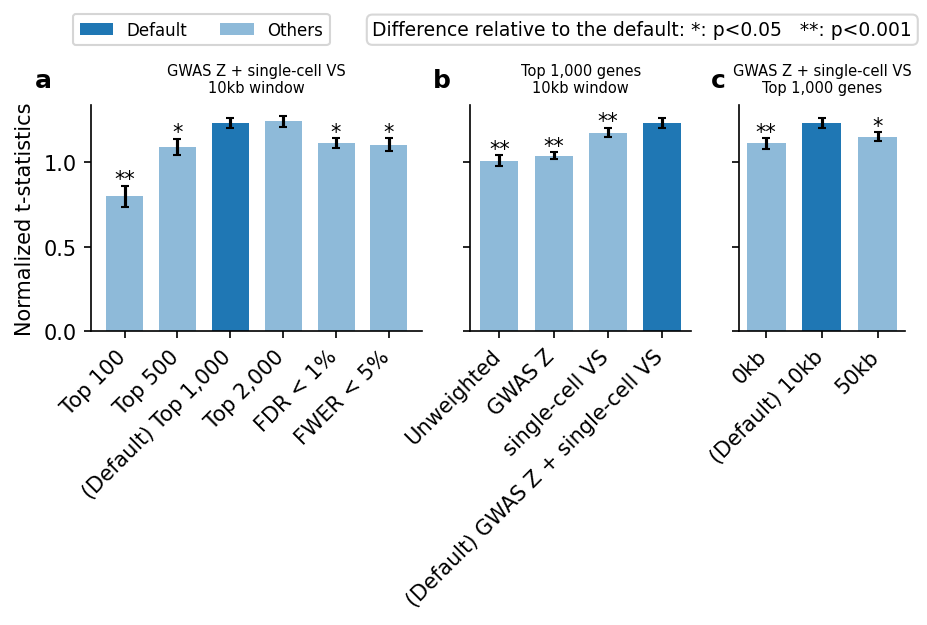

In [51]:
fig, axes = plt.subplots(
    figsize=(7, 2),
    dpi=150,
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [6, 4, 3]},
)

########################
# compare gene selection
########################

# fixing to zscore, vs, 10kb, varying gene selection
ax = axes[0]

df_tmp = dict_df_res["tstats"]
df_tmp = df_tmp[
    df_tmp.method.str.endswith("-zscore.vs") & (~df_tmp.method.str.contains("kb"))
].set_index("method")
mean = df_tmp["mean"].values
se = df_tmp["se"].values

print("Default method:")
print(df_tmp)
barplot = ax.bar(
    np.arange(len(mean)),
    mean,
    yerr=se,
    align="center",
    alpha=0.5,
    color="C0",
    ecolor="black",
    capsize=2,
    width=0.7,
)

# highlight default setting
barplot[2].set_facecolor("C0")
barplot[2].set_alpha(1.0)

# add asterisks for pairwise signficance
pval_list = df_pairwise_res.loc[
    df_tmp.index,
    "pval",
]

for i, (p, pval) in enumerate(zip(barplot.patches, pval_list)):
    if pval < 0.001:
        text = "**"
    elif pval < 0.05:
        text = "*"
    else:
        text = ""
    ax.text(p.get_x() + p.get_width() / 2.0, p.get_height() + se[i], text, ha="center")


label_dict = {
    "top-100-zscore.vs": "Top 100",
    "top-500-zscore.vs": "Top 500",
    "top-1000-zscore.vs": "(Default) Top 1,000",
    "top-2000-zscore.vs": "Top 2,000",
    "fwer5-2000-zscore.vs": "FWER < 5%",
    "fdr1-2000-zscore.vs": "FDR < 1%",
}
ax.set_ylabel(
    "Normalized t-statistics",
    fontsize=10,
)
ax.set_xticks(np.arange(len(mean)))
ax.set_xticklabels([label_dict[i] for i in df_tmp.index], rotation=45, ha="right")
ax.set_title("GWAS Z + single-cell VS\n10kb window", fontsize=7)

######################
# compare gene weights
######################
ax = axes[1]
order = [
    "top-1000-uniform.uniform",
    "top-1000-zscore.uniform",
    "top-1000-uniform.vs",
    "top-1000-zscore.vs",
]
df_tmp = dict_df_res["tstats"]
df_tmp = (
    df_tmp[df_tmp.method.str.startswith("top-1000")].set_index("method").reindex(order)
)
mean = df_tmp["mean"].values
se = df_tmp["se"].values

barplot = ax.bar(
    np.arange(len(mean)),
    mean,
    yerr=se,
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=2,
    width=0.7,
)
# highlight default setting
barplot[3].set_facecolor("C0")
barplot[3].set_alpha(1.0)


# add asterisks for pairwise signficance
pval_list = df_pairwise_res.loc[
    df_tmp.index,
    "pval",
]
for i, (p, pval) in enumerate(zip(barplot.patches, pval_list)):
    if pval < 0.001:
        text = "**"
    elif pval <= 0.05:
        text = "*"
    else:
        text = ""
    ax.text(p.get_x() + p.get_width() / 2.0, p.get_height() + se[i], text, ha="center")


ax.set_xticks(np.arange(len(mean)))
ax.set_xticklabels(
    ["Unweighted", "GWAS Z", "single-cell VS", "(Default) GWAS Z + single-cell VS"],
    rotation=45,
    fontsize=10,
    ha="right",
)

ax.set_title("Top 1,000 genes\n10kb window", fontsize=7)

######################
# compare window
######################
ax = axes[2]

df_tmp = dict_df_res["tstats"]
df_tmp = df_tmp[
    df_tmp.method.str.contains("kb") & (df_tmp.method.str.endswith("-zscore.vs"))
].set_index("method")
mean = df_tmp["mean"].values
se = df_tmp["se"].values


barplot = ax.bar(
    np.arange(len(mean)),
    mean,
    yerr=se,
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=2,
    width=0.7,
)
# highlight default setting
barplot[1].set_facecolor("C0")
barplot[1].set_alpha(1.0)


# add asterisks for pairwise signficance
pval_list = df_pairwise_res.loc[
    df_tmp.index,
    "pval",
]
for i, (p, pval) in enumerate(zip(barplot.patches, pval_list)):
    if pval < 0.001:
        text = "**"
    elif pval <= 0.05:
        text = "*"
    else:
        text = ""
    ax.text(p.get_x() + p.get_width() / 2.0, p.get_height() + se[i], text, ha="center")


ax.set_xticks(np.arange(len(mean)))
ax.set_xticklabels(
    ["0kb", "(Default) 10kb", "50kb"],
    rotation=45,
    fontsize=10,
    ha="right",
)
ax.set_title("GWAS Z + single-cell VS\nTop 1,000 genes", fontsize=7)

for i, ax in enumerate(axes):
    # annotation
    ax.text(
        -0.17,
        1.08,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    trans = mtrans.Affine2D().translate(5, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + trans)

handles = [
    Patch(facecolor="C0", label="Default", alpha=1.0),
    Patch(facecolor="C0", label="Others", alpha=0.5),
]
legend = fig.legend(
    handles=handles,
    bbox_to_anchor=(0.23, 1.13),
    loc="center",
    ncol=2,
    fontsize=8,
    frameon=True,
)

fig.text(
    0.65,
    1.112,
    "Difference relative to the default: *: p<0.05   **: p<0.001",
    ha="center",
    fontsize=9,
    bbox=dict(boxstyle="round", edgecolor="#D7D7D7", facecolor="white"),
)
plt.savefig("mainfig.pdf", bbox_inches="tight")
plt.savefig("mainfig.png", bbox_inches="tight")

# plt.tight_layout()

# Write supp. tables

In [10]:
def method_rename(n):
    gene_selection, gwas_weight = n.split(".")[0].rsplit("-", 1)
    sc_weight = n.split(".")[1]

    dict_gene_selection = {
        "top-100": "Top 100",
        "top-500": "Top 500",
        "top-1000": "Top 1,000",
        "top0kb-1000": "Top 1,000",
        "top10kb-1000": "Top 1,000",
        "top50kb-1000": "Top 1,000",
        "top-2000": "Top 2,000",
        "fdr1-2000": "FDR < 1%",
        "fwer5-2000": "FWER < 5%",
    }

    dict_weight = {
        ("uniform", "uniform"): "Unweighted",
        ("zscore", "uniform"): "GWAS Z",
        ("uniform", "vs"): "single-cell VS",
        ("zscore", "vs"): "GWAS Z + single-cell VS",
    }
    gene_selection = dict_gene_selection[gene_selection]
    weight = dict_weight[(gwas_weight, sc_weight)]
    if "kb" not in n:
        window = "10kb"
    else:
        window = n.split("-")[0][3:]
    return gene_selection, weight, window

In [11]:
df_tbl = pd.merge(
    dict_df_res["tstats"].set_index("method"),
    df_pairwise_res.rename(
        columns={"mean": "diff_mean", "se": "diff_se", "pval": "diff_pval"}
    ),
    left_index=True,
    right_index=True,
)

df_tbl = df_tbl.loc[
    [
        x
        for x in df_tbl.index
        if not x
        in [f"top{w}kb-1000-zscore.uniform" for w in [0, 10, 50]]
        + ["top10kb-1000-zscore.vs"]
    ]
]
df_tbl.index = pd.MultiIndex.from_tuples(
    [method_rename(x) for x in df_tbl.index],
    names=["gene selection", "gene weight", "window size"],
)
df_tbl.to_excel("results/power-benchmark.xlsx", na_rep="NA")